# Questionnaire Analysis
In this notebook we will see the questionnaire data and try to find relevant ways to include this in the models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return None
setup_mpl()


In [2]:
columns = ['Unnamed: 0', 'Parti']
df = pd.DataFrame()
for d in Path('../data/raw/dataset_extended').glob('D1_*'):
    for id_ in d.glob('ID_*'):
        for round_ in id_.glob('round_*'):
            for phase in round_.glob('phase*'):
                for file in phase.glob('*.csv'):
                    if file.name in ('response.csv',):
                        if df.empty:
                            df = pd.read_csv(file, index_col=None)
                            try:
                                df.participant_ID
                            except AttributeError:
                                df.rename(columns={'particpant_ID':'participant_ID'}, inplace=True)
                            if str(d.name)=='D1_2': #This is just stupid.. at least name them correctly yourself...
                                df['participant_ID'] = df['participant_ID'].tolist()[0]+8
                            df['cohort'] = d.name
                            df['phase'] = phase.name
                            df['round'] = round_.name
                            df['id'] = id_.name
                        else:
                            temp_df = pd.read_csv(file, index_col=None)
                            try:
                                temp_df.participant_ID
                            except AttributeError:
                                temp_df.rename(columns={'particpant_ID':'participant_ID'}, inplace=True)
                            if str(d.name)=='D1_2': #This is just stupid.. at least name them correctly yourself...
                                temp_df['participant_ID'] = temp_df['participant_ID'].tolist()[0]+8
                            temp_df['cohort'] = d.name
                            temp_df['phase'] = phase.name
                            temp_df['round'] = round_.name
                            temp_df['id'] = id_.name
                            df = pd.concat([df, temp_df], ignore_index=True)
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df.head()
len(sorted(df.participant_ID.unique())) # Nice

26

Lets check histogramplots of all the answers!

In [4]:
plotted_columns = ['upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 
                   'determined', 'attentive', 'afraid', 'active', 'frustrated', 
                  'difficulty']

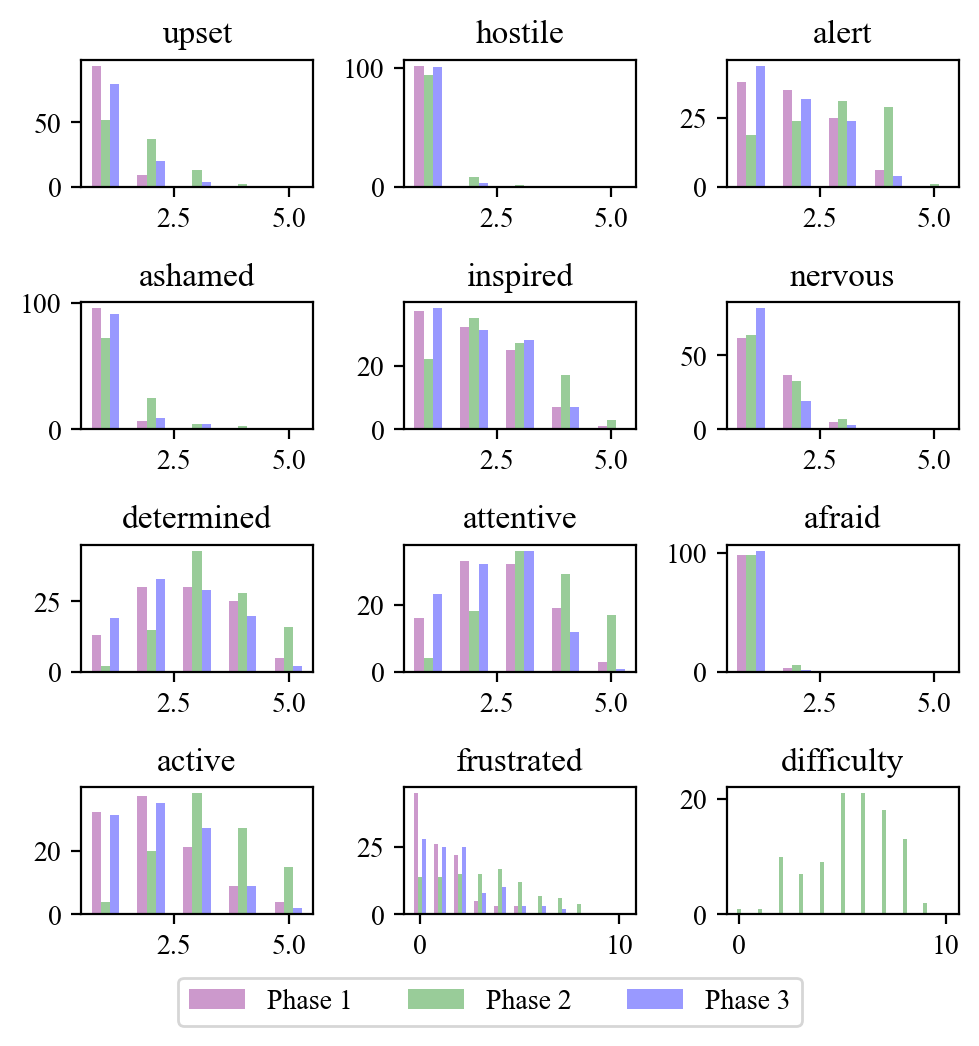

In [5]:
fig, ax = plt.subplots(4,3, figsize=(5,5), dpi=200)
row_idx = -1
for idx, question in enumerate(plotted_columns):
    if idx%3==0:
        col_idx = 0
        row_idx += 1
    for shift_idx, phase in enumerate(['phase1', 'phase2', 'phase3']):
        if shift_idx == 0:
            shift = -0.2
            color = 'purple'
            label = 'Phase 1'
        if shift_idx == 1:
            shift = 0
            color = 'green'
            label = 'Phase 2'
        if shift_idx == 2:
            shift = 0.2
            color = 'blue'
            label = 'Phase 3'
        numbers = [1,2,3,4,5]
        if idx>9:
            numbers = [0,1,2,3,4,5,6,7,8,9,10]
        for number in numbers:
            if idx == 0 and number == 5:
                ax[row_idx, col_idx].bar(number+shift, sum(df[df['phase']==phase][question]==number), width = 0.2, color=color, label=label, alpha=0.4)
            elif idx == 11:
                if phase == 'phase1' or phase == 'phase3':
                    continue
                ax[row_idx, col_idx].bar(number, sum(df[df['phase']=='phase2'][question]==number), width = 0.2, color='green', alpha=0.4)

            else:
                ax[row_idx, col_idx].bar(number+shift, sum(df[df['phase']==phase][question]==number), width = 0.2, color=color, alpha=0.4)
            ax[row_idx, col_idx].set_title(question)
    col_idx += 1
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
fig.savefig('bar_plot.png', bbox_inches='tight')
plt.show()


Man kan evt smide gennemsnit for hver phase ind også, så vi kan se, at grøn er different

Please note that there are 4 rounds so 4x26 counts in each phase ;)

In [6]:
roles = pd.DataFrame(columns = ['Unnamed: 0', 'ID', 'Team', 'Puzzler', 'cohort'])
for d in Path('../data/raw/dataset_extended').glob('D1_*'):
    file = '/team_info.csv'
    
    if roles.empty:
        roles = pd.read_csv(str(d)+file, index_col=None)
        roles['cohort'] = d.name
    
    else:
        temp_roles = pd.read_csv(str(d)+file, index_col=None)
        temp_roles['cohort'] = d.name
        roles = pd.concat([roles, temp_roles])


In [7]:
df_roles = df.merge(roles, left_on=['cohort','id'], right_on = ['cohort','ID'], how='inner')
len(sorted(df_roles.participant_ID.unique())) # Nice

26

In [8]:
matrix = df_roles.drop(['team_ID','puzzler','E4_nr','id','cohort','difficulty','parent','Unnamed: 0','Team','ID','Puzzler'], axis=1)

In [9]:
#matrix.loc[matrix['difficulty'].isnull(),'difficulty'] = 0
matrix_for_PCA = matrix.groupby(['phase','participant_ID']).median()


temp = matrix_for_PCA.reset_index()
#Create colormap based on phase
cmap = np.empty(len(temp), dtype="<U10")
cmap[list(temp[temp.phase=='phase1'].index)] = 'purple'
cmap[list(temp[temp.phase=='phase2'].index)] = 'green'
cmap[list(temp[temp.phase=='phase3'].index)] = 'blue'

C:\Users\jakob\AppData\Local\Temp\ipykernel_17892\3404436308.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  matrix_for_PCA = matrix.groupby(['phase','participant_ID']).median()


In [10]:
true_labels = matrix.groupby(['phase','participant_ID']).median().reset_index()['phase']
type(true_labels)

C:\Users\jakob\AppData\Local\Temp\ipykernel_17892\3257274269.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  true_labels = matrix.groupby(['phase','participant_ID']).median().reset_index()['phase']


pandas.core.series.Series

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(matrix_for_PCA)
matrix_plot = pca.transform(matrix_for_PCA)

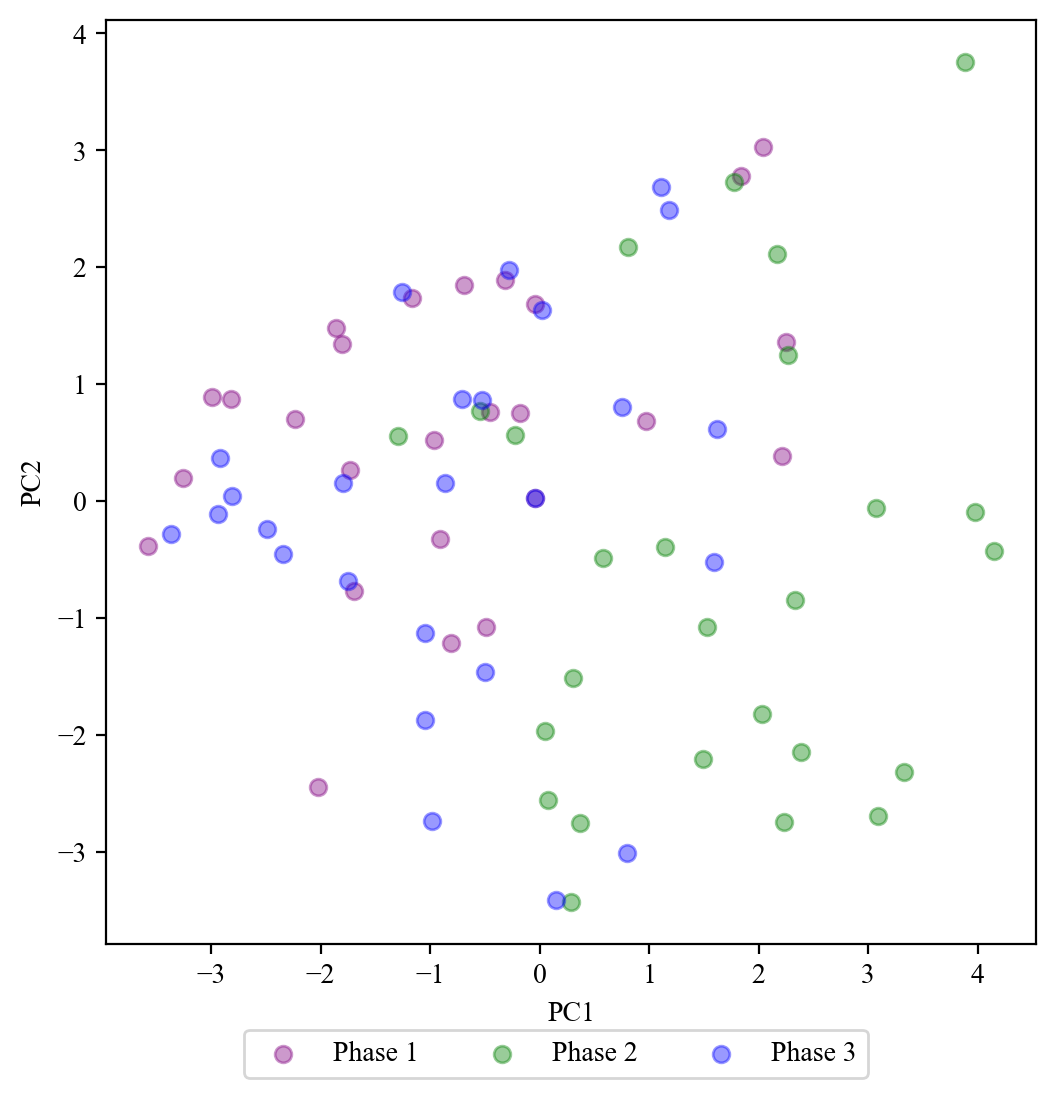

In [12]:
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
p1, p2, p3 = False, False, False
for i, color in enumerate(cmap):
    if color == 'purple':
        label = 'Phase 1'
    elif color == 'green':
        label = 'Phase 2'
    elif color == 'blue':
        label = 'Phase 3'
    if p1 == False and label == 'Phase 1':
        p1 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    elif p2 == False and label == 'Phase 2':
        p2 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    elif p3 == False and label == 'Phase 3':
        p3 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    else:
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, alpha=0.4)
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.05))
plt.show()

Looks like we can somehow separate Phase 2 from the other phases. Lets try a k-medoids clustering on the full data (high dimensional). Firsty we try 3-medoids clustering, however, it might be beneficial to see phase 1 and 3 as one cluster given the plot above..

Why medoids? Well it is ordinal data and taking the medoids instead of the centroids will preserve our scales so we can better interpret the results when depicting the prototypes!

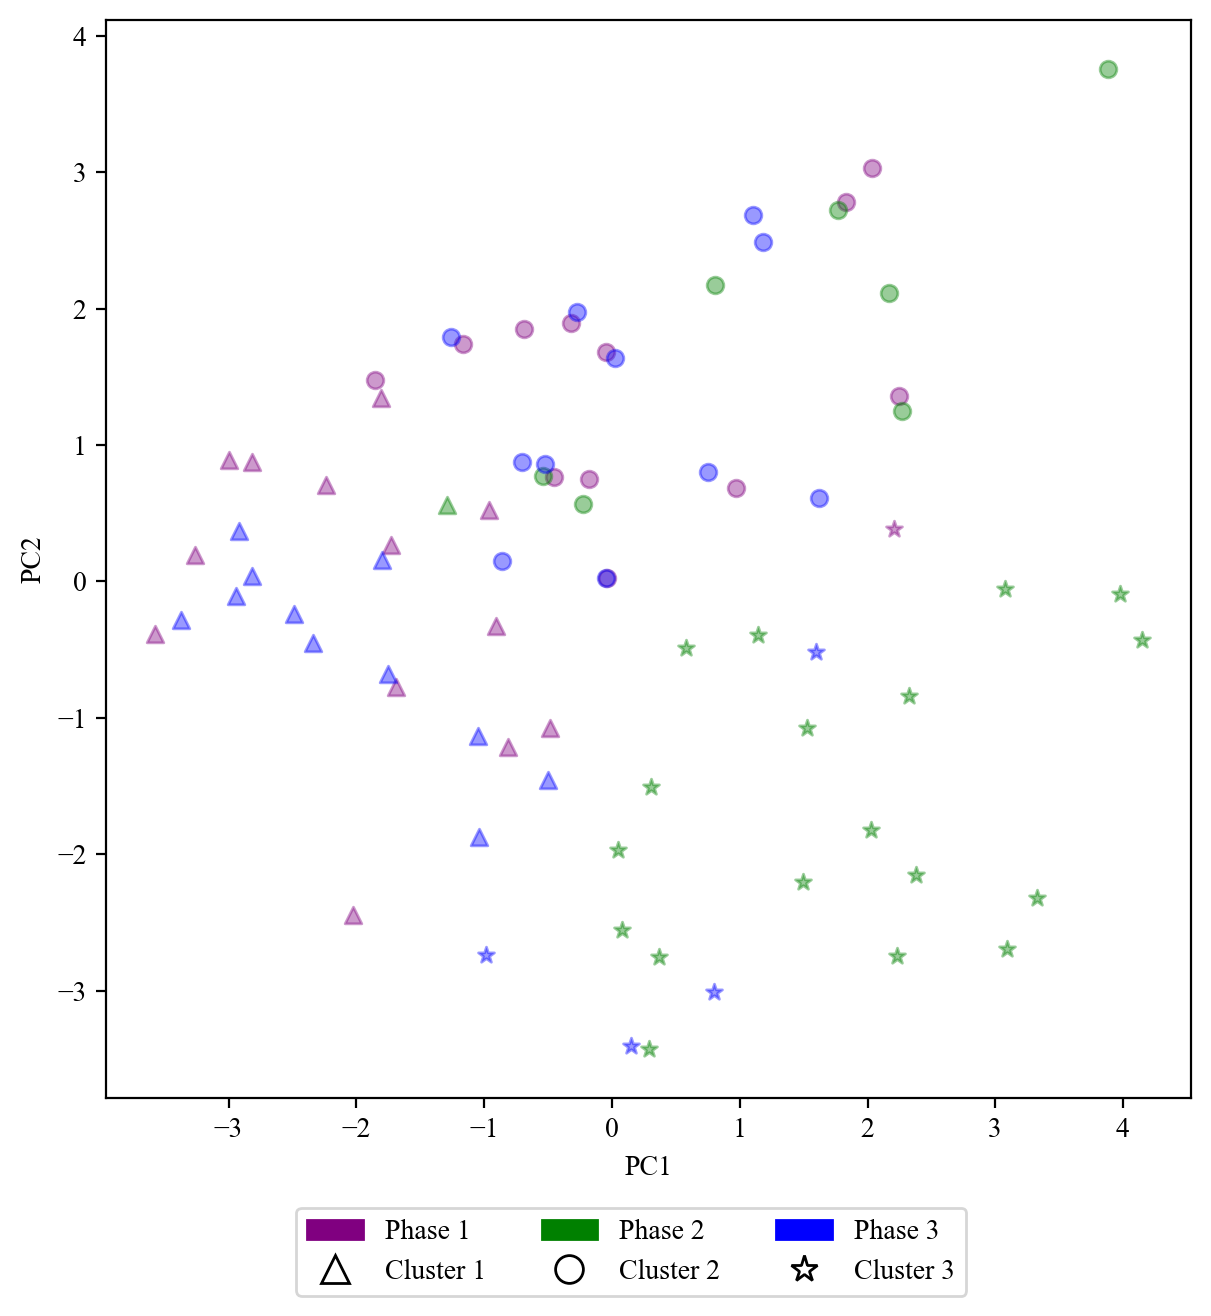

In [13]:
from sklearn_extra.cluster import KMedoids 
means3 = KMedoids(n_clusters = 3, random_state = 0)

X = np.array(matrix_for_PCA, dtype=float)
means3.fit(X)
temp = np.array(means3.labels_)
markers = np.empty(len(temp), dtype='<U10')
markers[np.argwhere(temp==0)] = '*'
markers[np.argwhere(temp==1)] = '^'
markers[np.argwhere(temp==2)] = 'o'

#Now we plot the same PCA plot but with types as k-medoid labels:
fig, ax = plt.subplots(figsize=(7,7), dpi=200)
p1, p2, p3 = False, False, False
for i, color in enumerate(cmap):
    if color == 'purple':
        label = 'Phase 1'
    elif color == 'green':
        label = 'Phase 2'
    elif color == 'blue':
        label = 'Phase 3'
    if p1 == False and label == 'Phase 1':
        p1 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    elif p2 == False and label == 'Phase 2':
        p2 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    elif p3 == False and label == 'Phase 3':
        p3 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    else:
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, alpha=0.4, marker=markers[i])
    
import matplotlib.patches as mpatches    
ph1 = mpatches.Patch(color='purple', label='Phase 1')
ph2 = mpatches.Patch(color='green', label='Phase 2')
ph3 = mpatches.Patch(color='blue', label='Phase 3')
import matplotlib.lines as mlines
tri = mlines.Line2D([], [], color='blue', marker='^', markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 1')
circ = mlines.Line2D([], [], marker='o',  markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 2')
star =  mlines.Line2D([], [], marker='*',  markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 3')
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 0), handles=[ph1, tri, ph2, circ, ph3, star])
#fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0))
#fig.savefig('k-means.png', bbox_inches='tight')
plt.show()


In [14]:
#Maybe we'll do some AA?
from py_pcha import PCHA
X = np.array(matrix_for_PCA)



# ARI/NMI
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
N = 10
ARI_AA =[]
NMI_AA = []
ARI_KM =[]
NMI_KM = []

for i in range(N):
    try:
        XC, S, C, SSE, varexpl = PCHA(X.T, noc=3, delta=0.1)
        medoid3 = KMedoids(n_clusters = 3, random_state = i)
        medoid3.fit(X)
        S = np.asarray(S) # Added because error for me (Jakob)
        ARI_AA.append(adjusted_rand_score(true_labels, S.argmax(axis=0)))
        NMI_AA.append(normalized_mutual_info_score(true_labels, S.argmax(axis=0)))
        ARI_KM.append(adjusted_rand_score(true_labels, medoid3.labels_))
        NMI_KM.append(normalized_mutual_info_score(true_labels, medoid3.labels_))
    except:
        continue
print('K=3, PC=2\t|\tN=10\n')
print(f"ARI (AA): {round(np.mean(ARI_AA), 5)} +- {round(1.96 * (np.std(ARI_AA)/np.sqrt(N)),5)}")
print(f"NMI (AA): {round(np.mean(NMI_AA), 5)} +- {round(1.96 * (np.std(NMI_AA)/np.sqrt(N)),5)}")
print("============================================")
print(f"ARI (KM): {round(np.mean(ARI_KM), 5)} +- {round(1.96 * (np.std(ARI_KM)/np.sqrt(N)),5)}")
print(f"NMI (KM): {round(np.mean(NMI_KM), 5)} +- {round(1.96 * (np.std(NMI_KM)/np.sqrt(N)),5)}")

#Do PCA to 2-D... We don't lose information as the simplex is on a plane already (nice)
pca = PCA(n_components=2)
pca.fit(S.T)
matrix_plot = pca.transform(S.T)

K=3, PC=2	|	N=10

ARI (AA): 0.23147 +- 0.0
NMI (AA): 0.26165 +- 0.0
ARI (KM): 0.17136 +- 0.0
NMI (KM): 0.21274 +- 0.0


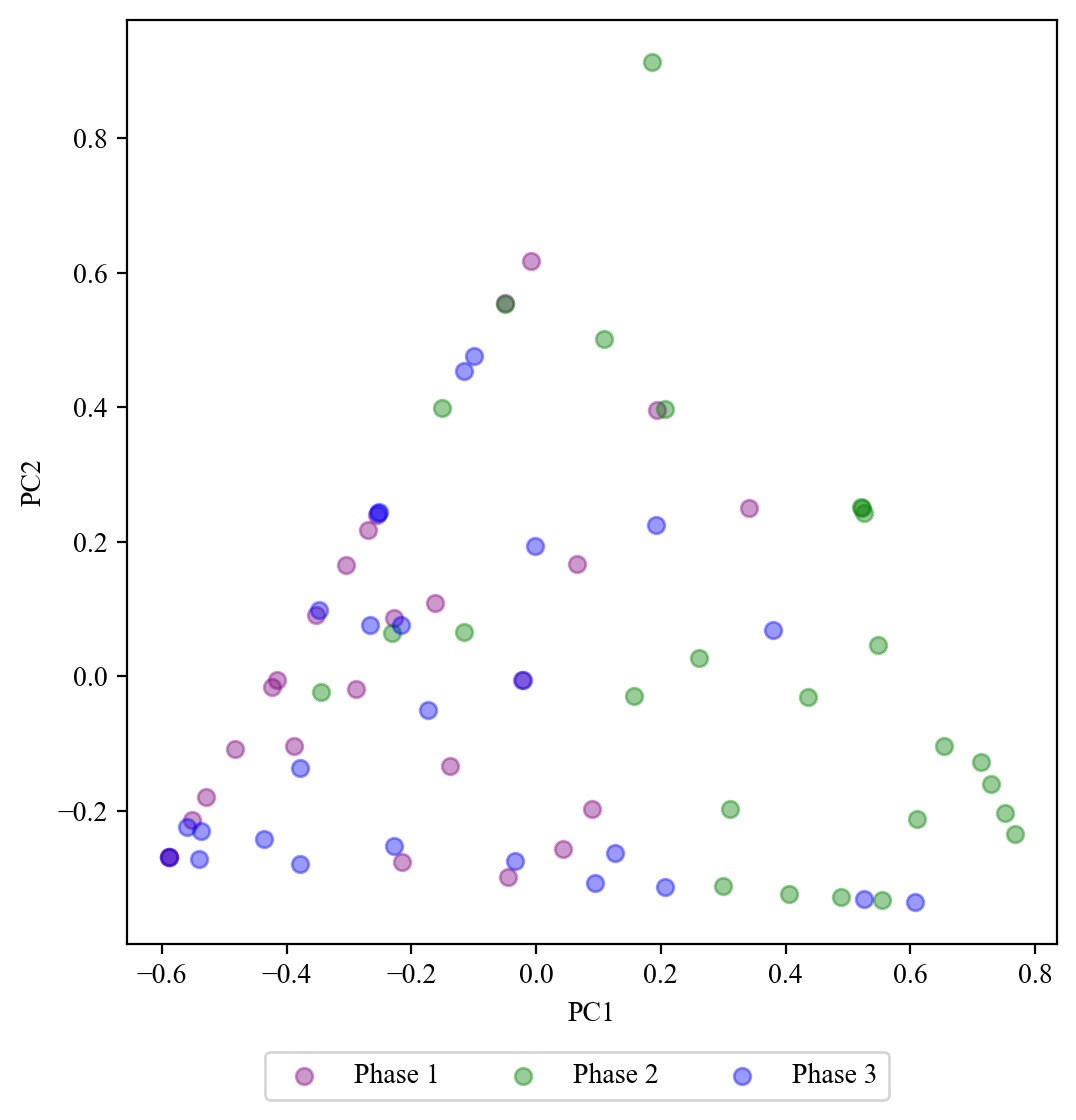

In [15]:
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
p1, p2, p3 = False, False, False
for i, color in enumerate(cmap):
    if color == 'purple':
        label = 'Phase 1'
    elif color == 'green':
        label = 'Phase 2'
    elif color == 'blue':
        label = 'Phase 3'
    if p1 == False and label == 'Phase 1':
        p1 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    elif p2 == False and label == 'Phase 2':
        p2 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    elif p3 == False and label == 'Phase 3':
        p3 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4)
    else:
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, alpha=0.4)
#plt.scatter(temp[:,0],temp[:,1], color='red')
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 0))
plt.show()

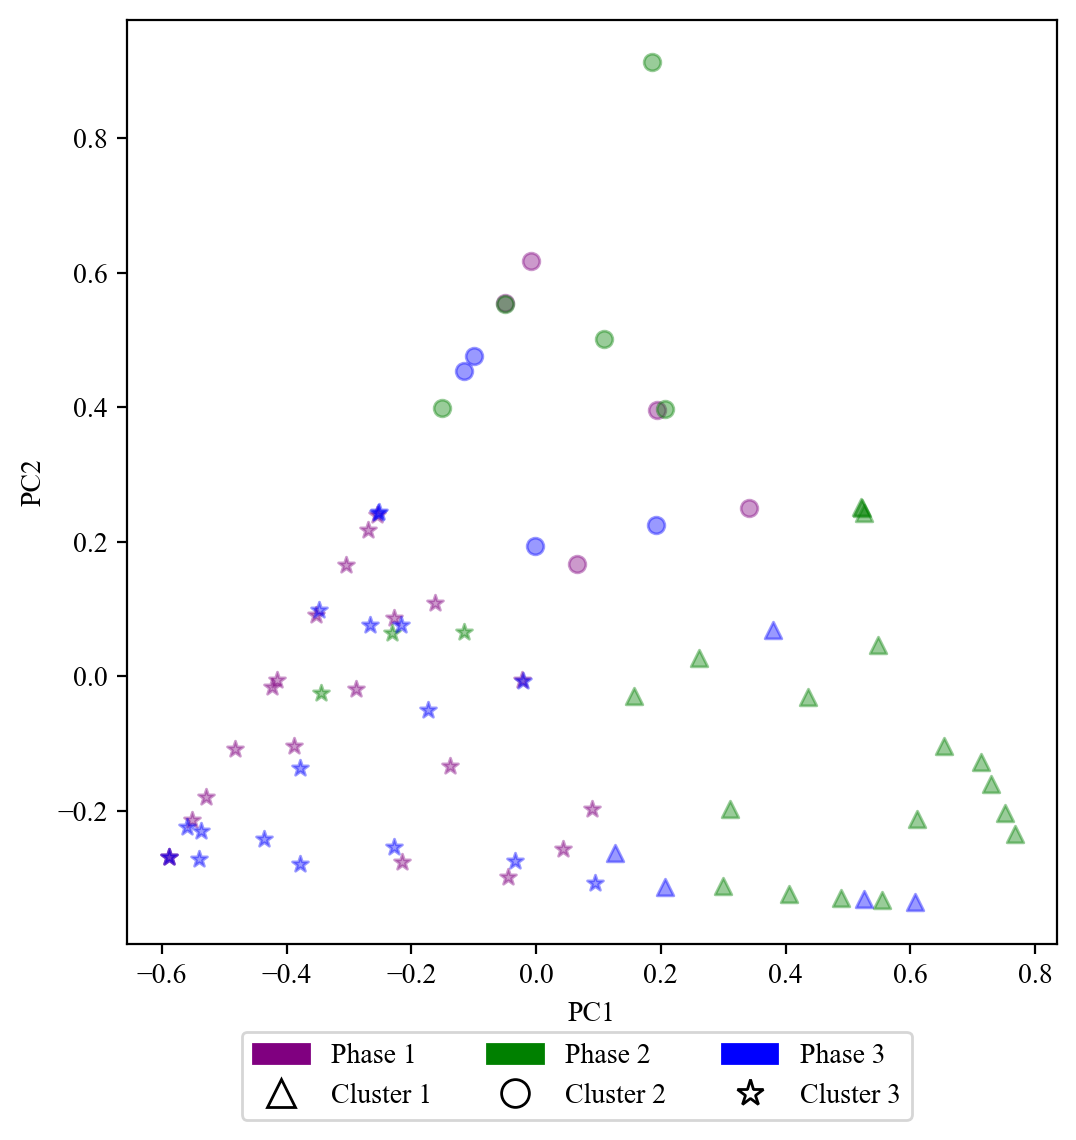

In [16]:
temp = S.T.argmax(1)
markers = np.empty(len(temp), dtype='<U10')
markers[np.argwhere(temp==0)] = '*'
markers[np.argwhere(temp==1)] = '^'
markers[np.argwhere(temp==2)] = 'o'

#Now we plot the same PCA plot but with types as k-medoid labels:
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
p1, p2, p3 = False, False, False
for i, color in enumerate(cmap):
    if color == 'purple':
        label = 'Phase 1'
    elif color == 'green':
        label = 'Phase 2'
    elif color == 'blue':
        label = 'Phase 3'
    if p1 == False and label == 'Phase 1':
        p1 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    elif p2 == False and label == 'Phase 2':
        p2 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    elif p3 == False and label == 'Phase 3':
        p3 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    else:
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, alpha=0.4, marker=markers[i])
#fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0))
import matplotlib.patches as mpatches    
ph1 = mpatches.Patch(color='purple', label='Phase 1')
ph2 = mpatches.Patch(color='green', label='Phase 2')
ph3 = mpatches.Patch(color='blue', label='Phase 3')
import matplotlib.lines as mlines
tri = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 1')
circ = mlines.Line2D([], [], marker='o',  markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 2')
star =  mlines.Line2D([], [], marker='*',  markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 3')
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.legend(loc='center', ncol=3, bbox_to_anchor=(0.5, 0), handles=[ph1, tri, ph2, circ, ph3, star])
fig.savefig('AA.png', bbox_inches='tight')
plt.show()

In [17]:
#Maybe we'll do some AA?
from py_pcha import PCHA
X = np.array(matrix_for_PCA)



# ARI/NMI
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
N = 10
ARI_AA =[]
NMI_AA = []
ARI_KM =[]
NMI_KM = []

for i in range(N):
    try:
        XC, S, C, SSE, varexpl = PCHA(X.T, noc=2, delta=0.1)
        medoid2 = KMedoids(n_clusters = 2, random_state = i)
        medoid2.fit(X)
        S = np.asarray(S) # Added because error for me (Jakob)
        ARI_AA.append(adjusted_rand_score(true_labels, S.argmax(axis=0)))
        NMI_AA.append(normalized_mutual_info_score(true_labels, S.argmax(axis=0)))
        ARI_KM.append(adjusted_rand_score(true_labels, medoid2.labels_))
        NMI_KM.append(normalized_mutual_info_score(true_labels, medoid2.labels_))
    except:
        continue
print('K=2, PC=2\t|\tN=10\n')
print(f"ARI (AA): {round(np.mean(ARI_AA), 5)} +- {round(1.96 * (np.std(ARI_AA)/np.sqrt(N)),5)}")
print(f"NMI (AA): {round(np.mean(NMI_AA), 5)} +- {round(1.96 * (np.std(NMI_AA)/np.sqrt(N)),5)}")
print("============================================")
print(f"ARI (KM): {round(np.mean(ARI_KM), 5)} +- {round(1.96 * (np.std(ARI_KM)/np.sqrt(N)),5)}")
print(f"NMI (KM): {round(np.mean(NMI_KM), 5)} +- {round(1.96 * (np.std(NMI_KM)/np.sqrt(N)),5)}")

#Do PCA to 2-D... We don't lose information as the simplex is on a plane already (nice)
pca = PCA(n_components=2)
pca.fit(S.T)
matrix_plot = pca.transform(S.T)

K=2, PC=2	|	N=10

ARI (AA): 0.14383 +- 0.0
NMI (AA): 0.14603 +- 0.0
ARI (KM): 0.16881 +- 0.0
NMI (KM): 0.1679 +- 0.0


## Roles


In [ ]:
matrix = df_roles.drop(['team_ID','puzzler','E4_nr','id','cohort','difficulty','parent','Unnamed: 0','Team','ID','phase'], axis=1)

In [ ]:
#matrix.loc[matrix['difficulty'].isnull(),'difficulty'] = 0
matrix_for_PCA = matrix.groupby(['Puzzler','participant_ID']).median()
true_labels = matrix.groupby(['Puzzler','participant_ID']).median().reset_index()['Puzzler']
type(true_labels)

temp = matrix_for_PCA.reset_index()
#Create colormap based on phase
cmap = np.empty(len(temp), dtype="<U10")
cmap[list(temp[temp.Puzzler==0].index)] = 'blue'
cmap[list(temp[temp.Puzzler==1].index)] = 'red'

In [ ]:
#Maybe we'll do some AA?
from py_pcha import PCHA
X = np.array(matrix_for_PCA)

# ARI/NMI
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
N = 2
ARI_AA = []
NMI_AA = []
ARI_KM = []
NMI_KM = []
from sklearn_extra.cluster import KMedoids 
for i in range(N):
    try:
        XC, S, C, SSE, varexpl = PCHA(X.T, noc=2, delta=0.1)
        S = np.asarray(S) # Added because error for me (Jakob)
        means3 = KMedoids(n_clusters = 2, random_state = i)
        means3.fit(X)
        ARI_AA.append(adjusted_rand_score(true_labels, S.argmax(axis=0)))
        NMI_AA.append(normalized_mutual_info_score(true_labels, S.argmax(axis=0)))
        ARI_KM.append(adjusted_rand_score(true_labels, means3.labels_))
        NMI_KM.append(normalized_mutual_info_score(true_labels, means3.labels_))
    except:
        continue
print(f"ARI (AA): {np.mean(ARI_AA)} +- {np.std(ARI_AA)}")
print(f"NMI (AA): {np.mean(NMI_AA)} +- {np.std(NMI_AA)}")
print("============================================")
print(f"ARI (KM): {np.mean(ARI_KM)} +- {np.std(ARI_KM)}")
print(f"NMI (KM): {np.mean(NMI_KM)} +- {np.std(NMI_KM)}")
    
matrix_plot = S.T


X = np.array(matrix_for_PCA, dtype=float)
means3.fit(X)
temp = np.array(means3.labels_)
markers = np.empty(len(temp), dtype='<U10')
markers[np.argwhere(temp==0)] = '*'
markers[np.argwhere(temp==1)] = '^'

#print(matrix_plot.shape)

#Now we plot the same PCA plot but with types as k-medoid labels:
fig, ax = plt.subplots(figsize=(7,7))
p1, p2 = False, False
for i, color in enumerate(cmap):
    if color == 'blue':
        label = 'Instructor'
    elif color == 'red':
        label = 'Puzzler'
    if p1 == False and label == 'Instructor':
        p1 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    elif p2 == False and label == 'Puzzler':
        p2 = True
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, label=label, alpha=0.4, marker=markers[i])
    else:
        plt.scatter(matrix_plot[i,0], matrix_plot[i,1], color = color, alpha=0.4, marker=markers[i])
    
import matplotlib.patches as mpatches    
ph1 = mpatches.Patch(color='red', label='Instructor')
ph2 = mpatches.Patch(color='blue', label='Puzzler')
import matplotlib.lines as mlines
tri = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 1')
star =  mlines.Line2D([], [], marker='*',  markerfacecolor='None', markeredgecolor='black', linestyle='None',
                          markersize=10, label='Cluster 2')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0), handles=[ph1, tri, ph2, star])
#fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0))
#fig.savefig('k-means.png', bbox_inches='tight')
plt.show()


In [ ]:
print(matrix_plot.shape)
print(S.shape)

# Lets plot some Arche- and Prototypes!

In [ ]:
cols = list(matrix_for_PCA.columns)
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(XC[:,0], color = 'purple', label='Archetype 1', alpha=0.3, marker='o', linestyle='None')
plt.plot(XC[:,1], color = 'green', label='Archetype 2', alpha=0.3, marker='o',linestyle='None')
plt.plot(XC[:,2], color = 'blue', label='Archetype 3', alpha=0.3, marker='o',linestyle='None')
ax.set_xticks(range(len(cols)))
ax.set_xticklabels(cols, rotation='vertical', fontsize=18)
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.10))
plt.show()

AA is not really a good measure if you want to keep the scale and see what an archetypal person would answer, however, the relative scale should be intact; a score of 5.01 > 2.32! So we can say that A1 is much more frustrated than A2 and A3 but you can't say how much more! There exists AA for ordinal data, however, it is not in scope of the course https://www.sciencedirect.com/science/article/pii/S002002552100791X.

For now we will focus on which assumptions we hold while applying AA to our questionnaire and how this may limit our conclusion.

In [ ]:
cols = list(matrix_for_PCA.columns)
label = np.array(means3.labels_)
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(np.median(X[np.argwhere(label==0),:].squeeze(1),0), color = 'purple', label='Archetype 1', alpha=0.3, marker='o', linestyle='None')
plt.plot(np.median(X[np.argwhere(label==1),:].squeeze(1),0), color = 'green', label='Archetype 2', alpha=0.3, marker='o',linestyle='None')
plt.plot(np.median(X[np.argwhere(label==2),:].squeeze(1),0), color = 'blue', label='Archetype 3', alpha=0.3, marker='o',linestyle='None')
ax.set_xticks(range(len(cols)))
ax.set_xticklabels(cols, rotation='vertical', fontsize=18)
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.10))
plt.show()

In [ ]:
#Something